# still under construction

# CAHSEE Data Exploration

The California High School Exit Examination (CAHSEE) was a state mandated test for students graduating high school. It tested students on ELA and Math. It was recently (2017) repealed. The California Department of Education has 2002-2015 data available on their website. In the first part of my project I wrote a small script to extract the data for analysis. In this exploratory project I'll pull one years data and take a look.

In [2]:
import boto3
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Getting the data
Let's connect to S3 and grab the bucket that contains our data: 

In [3]:
s3 = boto3.client('s3')
bucket = 'personproject.b'

In [4]:
csv_obj = s3.get_object(Bucket=bucket, Key='cahsee2015.txt')
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df = pd.read_csv(StringIO(csv_string), sep = "\t", dtype={"CountyCode": object, "DistrictCode": object, "CharterNumber": object, "SchoolCode": object, "MathTestDate": object, "ELATestDate": object, 
                                                          "ELAPercentNotPassed": float, "GradeLevel": object})

In [77]:
cahsee_15 = df

## Brief summary of fields

The California Department of Education provides layout files for the data here: https://cahsee.cde.ca.gov/filestruct2015.asp

For this project the following is most relevant:
<ul><b>Record Type:</b> Classifies the level of data 
<li>04=state
<li>05=county
<li>06=district
<li>07=school
    </ul>

<ul><b>SummaryType:</b> Subgroup
<li>01=All Students Tested

<li>02=Grade 10

<li>03=Grade 11

<li>04=Grade 12

<li>05=Grade AE

<li>06=Grade Unknown

<li>07=Male

<li>08=Female

<li>09=Gender Unknown

<li>10=American Indian or Alaskan Native

<li>11=Asian

<li>12=Pacific Islander
    <br>...
<li>47= Not Eco. Disadvantaged Two or More Races


    
</ul>


For this particular small project I do not want to work with all the data, so I'll look at the file layout and also examine the data further and pick which ones I'm interested in looking at.

In [78]:
cahsee_15.columns.values

array(['CountyCode', 'DistrictCode', 'CharterNumber', 'SchoolCode',
       'CountyName', 'DistrictName', 'SchoolName', 'RecordType',
       'SummaryType', 'Administration', 'MathTestDate',
       'MathGrade10AnswerSheetsProcessed', 'MathNumberTested',
       'MathNumberPassed', 'MathPercentPassed', 'MathNumberNotPassed',
       'MathPercentageNotPassed', 'MathMEanScaleScore',
       'MathPSPercentCorrect', 'MathNSPercentCorrect',
       'MathAFPercentCorrect', 'MathMGPercentCorrect',
       'MathA1PercentCorrect', 'ELATestDate',
       'ELAGrade10AnswerSheetsProcessed', 'ELANumberTested',
       'ELANumberPassed', 'ELAPercentPassed', 'ELANumberNotPassed',
       'ELAPercentNotPassed', 'ELAMeanScaleScore', 'ELAWAPercentCorrect',
       'ELARCPercentCorrect', 'ELALRAPercentCorrect',
       'ELAWSPercentCorrect', 'ELAWCPercentCorrect', 'ELAES1AvgScore',
       'Filler', 'SystemDate', 'GradeLevel', 'MathPercentProfAndAbove',
       'ELAPercentProfAndAbove', 'Unnamed: 42'], dtype=object)

In [79]:
cahsee_15.head(3)

,CountyCode,DistrictCode,CharterNumber,SchoolCode,CountyName,DistrictName,SchoolName,RecordType,SummaryType,Administration,...,ELALRAPercentCorrect,ELAWSPercentCorrect,ELAWCPercentCorrect,ELAES1AvgScore,Filler,SystemDate,GradeLevel,MathPercentProfAndAbove,ELAPercentProfAndAbove,Unnamed: 42
0,01,00000,000,0000000,Alameda County,,,5,1,S,...,53.0,43.0,55.0,2.0,0,07/28/15,12,0.0,0.0,NaN
1,01,00000,000,0000000,Alameda County,,,5,7,S,...,53.0,43.0,55.0,2.0,0,07/28/15,12,0.0,0.0,NaN
2,01,00000,000,0000000,Alameda County,,,5,8,S,...,52.0,43.0,56.0,2.1,0,07/28/15,12,0.0,0.0,NaN


In [80]:
cahsee_15 = cahsee_15[['CountyCode', 'DistrictCode', 'SchoolCode','CountyName','DistrictName', 'SchoolName', 'RecordType', 'SummaryType', 
    'GradeLevel','MathGrade10AnswerSheetsProcessed','MathNumberTested', 'MathPercentPassed', 'MathPercentProfAndAbove', 
       'ELAGrade10AnswerSheetsProcessed', 'ELANumberTested', 'ELAPercentPassed', 'ELAPercentProfAndAbove']]

## Validating and Cleaning

In [81]:
cahsee_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715380 entries, 0 to 715379
Data columns (total 17 columns):
CountyCode                          715380 non-null object
DistrictCode                        715380 non-null object
SchoolCode                          715380 non-null object
CountyName                          715380 non-null object
DistrictName                        715380 non-null object
SchoolName                          715380 non-null object
RecordType                          715380 non-null int64
SummaryType                         715380 non-null int64
GradeLevel                          715380 non-null object
MathGrade10AnswerSheetsProcessed    715380 non-null int64
MathNumberTested                    715380 non-null int64
MathPercentPassed                   715380 non-null float64
MathPercentProfAndAbove             715380 non-null float64
ELAGrade10AnswerSheetsProcessed     715380 non-null int64
ELANumberTested                     715380 non-null int64
ELAPerce

While the report uses dashes to represent suppressed data for number tested (n) <= 10, the file represents supressed data as 0's in the data rows. We'll manually suppress these rows 

In [82]:
cahsee_15.loc[cahsee_15['MathNumberTested'] <= 10, ['MathPercentProfAndAbove','MathPercentPassed']] = None
cahsee_15.loc[cahsee_15['ELANumberTested'] <= 10, ['ELAPercentProfAndAbove','ELAPercentPassed']] = None

/Users/Kimberly/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now I'll make map the number codes to more meaningful values.

In [83]:
data_levels = {4: "state", 5: "county", 6: 'district', 7:'school'}

summary_levels = {1: 'All Students', 2: 'Grade 10', 3: 'Grade 11', 4:'Grade 12', 5:'Grade AE', 6: 'Grade Unknown',
                 7: 'Male', 8:'Female', 9: 'Gender Unknown', 10: 'American Indian or Alaskan Native', 11:'Asian',
                  12: 'Pacific Islander', 13:'Filipino', 14: 'Hispanic or Latino', 15:'African American or Black', 16:'White',
                  17: 'Two or More Races',19: 'English Only',20: 'Initially Fluent English Proficient (IFEP)', 21:'Redesignated Fluent English Proficient (RFEP)',
                  22:' English Learner (EL)',23: 'Language Fluency Unknown',24: 'Not Economically Disadvantaged',25: 'Economically Disadvantaged',
                  26: 'Economic Status Unknown',28: 'Participating in Migrant Education Program',29: 'Participating in Special Education Program',
                  30: 'Tested with modifications'}

cahsee_15 = cahsee_15.replace({"RecordType": data_levels})
cahsee_15 = cahsee_15.replace({"SummaryType": summary_levels})

print(cahsee_15.RecordType.unique())
print(cahsee_15.SummaryType.unique())

['county' 'district' 'school' 'state']
['All Students' 'Male' 'Female' 'American Indian or Alaskan Native'
 'Asian' 'Pacific Islander' 'Filipino' 'Hispanic or Latino'
 'African American or Black' 'White' 'Two or More Races' 'English Only'
 'Initially Fluent English Proficient (IFEP)'
 'Redesignated Fluent English Proficient (RFEP)' ' English Learner (EL)'
 'Language Fluency Unknown' 'Not Economically Disadvantaged'
 'Economically Disadvantaged' 'Economic Status Unknown'
 'Participating in Special Education Program' 'Tested with modifications'
 'Grade 12' 'Grade AE' 'Gender Unknown'
 'Participating in Migrant Education Program' 'Grade 11' 31 32 33 34 35 36
 37 38 40 41 42 43 44 45 46 47 'Grade 10' 'Grade Unknown']


In [84]:
cahsee_15.head()

,CountyCode,DistrictCode,SchoolCode,CountyName,DistrictName,SchoolName,RecordType,SummaryType,GradeLevel,MathGrade10AnswerSheetsProcessed,MathNumberTested,MathPercentPassed,MathPercentProfAndAbove,ELAGrade10AnswerSheetsProcessed,ELANumberTested,ELAPercentPassed,ELAPercentProfAndAbove
0,01,00000,0000000,Alameda County,,,county,All Students,12,0,188,18.0,0.0,0,227,22.0,0.0
1,01,00000,0000000,Alameda County,,,county,Male,12,0,87,16.0,0.0,0,124,24.0,0.0
2,01,00000,0000000,Alameda County,,,county,Female,12,0,101,19.0,0.0,0,103,20.0,0.0
3,01,00000,0000000,Alameda County,,,county,American Indian or Alaskan Native,12,0,1,NaN,NaN,0,1,NaN,NaN
4,01,00000,0000000,Alameda County,,,county,Asian,12,0,17,29.0,0.0,0,49,14.0,0.0


In [85]:
cahsee_15.MathGrade10AnswerSheetsProcessed.value_counts(normalize = True)

0       0.441715
1       0.016478
2       0.016456
3       0.014155
4       0.012739
5       0.012427
7       0.010443
6       0.009926
8       0.009867
9       0.009210
11      0.008696
10      0.008507
12      0.008260
14      0.007701
13      0.006924
17      0.006514
20      0.006205
15      0.005930
22      0.005575
19      0.005361
16      0.005269
18      0.004874
21      0.004447
23      0.003615
25      0.003570
28      0.003517
24      0.003393
27      0.003307
26      0.003209
29      0.003082
          ...   
677     0.000045
761     0.000045
1037    0.000045
1011    0.000045
348     0.000045
389     0.000045
404     0.000045
1249    0.000043
1256    0.000043
303     0.000043
903     0.000042
758     0.000042
742     0.000042
1198    0.000042
1103    0.000041
753     0.000041
635     0.000041
1126    0.000041
1113    0.000041
577     0.000039
862     0.000039
869     0.000039
681     0.000038
966     0.000038
259     0.000038
505     0.000036
270     0.000035
712     0.0000

I noticed the Percent Prof and Above columns for both subjects are showing 0% for the first few rows along with the MathGrade10AnswerSheetsProcessed despite having data in the other columns, so I decided to check the frequency of 0's in the math column. This is a good time to explore further and detangle the differences between the columns such as Percent Passed and Percent Prof Above. Consulting this research file https://www.cde.ca.gov/ta/tg/hs/documents/cahsee1415explained.pdf

"<b>Percent Passed</b> – This represents the percentage of students who received
a passing score. The percent passed is calculated by dividing the number
passed by the number tested and multiplying by 100.

<b>Percent Proficient</b> and Above – This represents the percentage of <u>grade
ten</u> students who received a performance level of proficient or above (i.e., a
scale score of 380 or greater)."

It looks like there's a distinction between all students and grade 10 students, which should be kept in mind when analyzing or visualizing the data. This wasn't made obvious in the provided layout file, but digging around for more information on the data was useful.

## Visualizations and Exploration

For all the below visualizations it's necessary to pick a level of granularity (district, school, county) to avoid double counting data. I'll also be choosing between visualizing grade 10 results, or overall results. There's no 'correct' choice for any of the following visualizations. It depends on what you want to explore! In general I try to follow common principles for data visualization - for example I don't want to make a dense scatter plot where the difference between points is not easy to decipher. Therefore, plotting school level data on a traditional scatter plot will not be my first choice. I could probably tell the same story by using county level data.

### Checking for outliers

Below I see what I'd expect for test scores - means close to 50% with a minimm of 0% and a maximum of 100%.

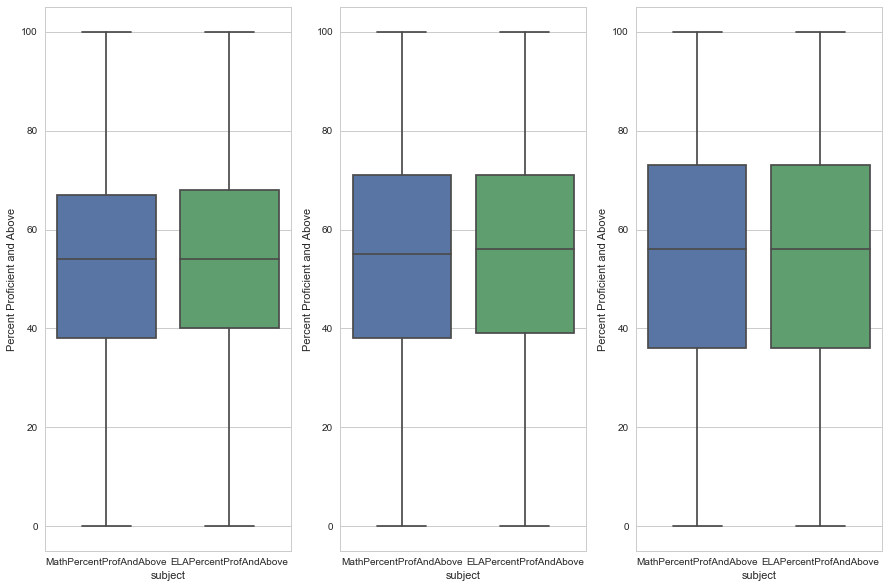

In [134]:
import seaborn as sns
county_level_grade_10 = cahsee_15.loc[(cahsee_15['RecordType'] == 'county') 
                                      & (cahsee_15['GradeLevel'] == '10'), ['MathPercentProfAndAbove', 'ELAPercentProfAndAbove'] ]
district_level_grade_10 = cahsee_15.loc[(cahsee_15['RecordType'] == 'district') 
                                      & (cahsee_15['GradeLevel'] == '10'), ['MathPercentProfAndAbove', 'ELAPercentProfAndAbove'] ]
school_level_grade_10 = cahsee_15.loc[(cahsee_15['RecordType'] == 'school') 
                                      & (cahsee_15['GradeLevel'] == '10'), ['MathPercentProfAndAbove', 'ELAPercentProfAndAbove'] ]


fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,10))

sns.boxplot(x="variable", y="value", data=pd.melt(county_level_grade_10), ax = ax1).set(
    xlabel='subject', 
    ylabel='Percent Proficient and Above')
sns.boxplot(x="variable", y="value", data=pd.melt(district_level_grade_10), ax = ax2).set(
    xlabel='subject', 
    ylabel='Percent Proficient and Above')
sns.boxplot(x="variable", y="value", data=pd.melt(school_level_grade_10), ax = ax3).set(
    xlabel='subject', 
    ylabel='Percent Proficient and Above')

plt.show()

### Comparing overall Male and Female test scores

/Users/Kimberly/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/Kimberly/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


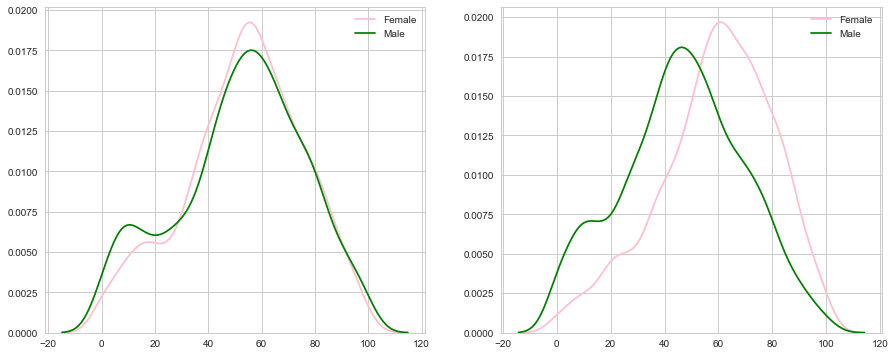

In [193]:
#gender_filter = cahsee_15.loc[cahsee_15['SummaryType'].isin(['Female', 'Male'])]
female = cahsee_15.loc[(cahsee_15['RecordType'] == 'school') 
                                      & (cahsee_15['SummaryType'] == 'Female')
                                      & (cahsee_15['GradeLevel'] == '10'), ['MathPercentProfAndAbove', 'ELAPercentProfAndAbove']]
male = cahsee_15.loc[(cahsee_15['RecordType'] == 'school') 
                                      & (cahsee_15['SummaryType'] == 'Male')
                                      & (cahsee_15['GradeLevel'] == '10'), ['MathPercentProfAndAbove', 'ELAPercentProfAndAbove']]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))

sns.kdeplot(female['MathPercentProfAndAbove'], ax = ax1, label = 'Female', color = 'pink')
sns.kdeplot(male['MathPercentProfAndAbove'], ax = ax1, label = 'Male', color = 'green')
sns.kdeplot(female['ELAPercentProfAndAbove'], ax = ax2, label = 'Female', color = 'pink')
sns.kdeplot(male['ELAPercentProfAndAbove'], ax = ax2, label = 'Male', color = 'green')


## Geographic Data

Next I'll incorporate a dataset I found from CDE containing geographic information for public schools. After examining the columns in both files I'll try to join the two by combining the county, district, and school code in the data file to match the CDS code.

In [195]:
ca_directory = pd.read_table("./data/pubschls.txt", sep = "\t", dtype = {"CDSCode" : object, "NCESDist": object, "NCESSchool": object} )
ca_directory.columns.values

array(['CDSCode', 'NCESDist', 'NCESSchool', 'StatusType', 'County',
       'District', 'School', 'Street', 'StreetAbr', 'City', 'Zip',
       'State', 'MailStreet', 'MailStrAbr', 'MailCity', 'MailZip',
       'MailState', 'Phone', 'Ext', 'WebSite', 'OpenDate', 'ClosedDate',
       'Charter', 'CharterNum', 'FundingType', 'DOC', 'DOCType', 'SOC',
       'SOCType', 'EdOpsCode', 'EdOpsName', 'EILCode', 'EILName',
       'GSoffered', 'GSserved', 'Virtual', 'Magnet', 'Latitude',
       'Longitude', 'AdmFName1', 'AdmLName1', 'AdmEmail1', 'AdmFName2',
       'AdmLName2', 'AdmEmail2', 'AdmFName3', 'AdmLName3', 'AdmEmail3',
       'LastUpDate'], dtype=object)

In [196]:
cahsee_15['CDSCode'] = cahsee_15['CountyCode'] + cahsee_15['DistrictCode'] + cahsee_15['SchoolCode']
cahsee_15.loc[cahsee_15['SchoolName'] == 'Alameda High', 'CDSCode'].unique() == ca_directory.loc[ca_directory['School'] == 'Alameda High', 'CDSCode'].unique()

array([ True])

In [201]:
geo_cahsee_15 = pd.merge(cahsee_15, ca_directory.loc[:, ['CDSCode', 'Street', 'City', 'Zip','Latitude', 'Longitude']], 
                left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

Now I'll move on to plotting the test scores on a map. Similar to previous visualizations I need to limit the data to one level - displaying county, district, or school level data to avoid duplicated data. I'm not performing an indepth analysis, but I am curious about the location of scores in relation to high income and metropolitan areas. In a future project pulling this data in could be interesting. For this visualization I'll use the school data to aggregate by city.

In [203]:
data = geo_cahsee_15.loc[(cahsee_15['RecordType'] == 'school') 
                                      & (cahsee_15['GradeLevel'] == '10')]

In [204]:
df = data.groupby('City').agg({'MathPercentPassed':'mean', 'MathPercentProfAndAbove':'mean',
                                        'ELAPercentPassed': 'mean', 'ELAPercentProfAndAbove': 'mean',
                                       'Latitude': 'mean', 'Longitude': 'mean', 'CDSCode': 'nunique'})[['MathPercentPassed','MathPercentProfAndAbove',
                                                                                 'ELAPercentPassed', 'ELAPercentProfAndAbove',
                                                                                 'Latitude', 'Longitude', 'CDSCode']].reset_index()
df.head()

,City,MathPercentPassed,MathPercentProfAndAbove,ELAPercentPassed,ELAPercentProfAndAbove,Latitude,Longitude,CDSCode
0,Acton,86.428571,30.000000,77.285714,35.428571,34.482984,-118.206185,3
1,Adelanto,40.875000,14.500000,49.312500,17.250000,34.531124,-117.441300,1
2,Agoura,68.833333,0.000000,66.500000,0.000000,34.151016,-118.749432,2
3,Alameda,80.556338,35.774648,78.099291,34.283688,37.775425,-122.277664,7
4,Alhambra,27.000000,0.000000,NaN,NaN,34.091236,-118.141940,1


### Matplotlib

I'm most familiar with matplotlib, so I'll start off using this library. The issue with this approach is that the latitude and longitude is not directly tied to the background image. This means the location of the points are not 100% accurate. I attempted to fix the extent by examining the minimum and maximum lat and lon. I personally wouldn't use this approach in practice, but it was fun to try. Tableau makes really cool dashboards using geographical data. 

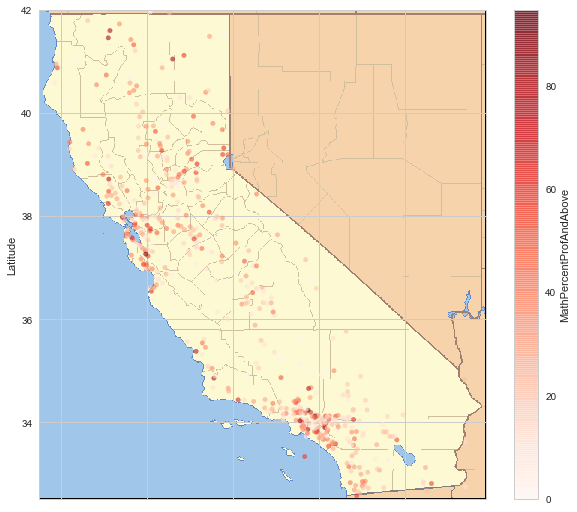

In [213]:
img=mpimg.imread('california.png')

ax = df.plot(x='Longitude', y='Latitude', kind='scatter', alpha=0.6, 
         c= 'MathPercentProfAndAbove', cmap=plt.get_cmap("Reds"), colorbar=True, 
         zorder=1, figsize=(10,9) )

plt.imshow(img,aspect = 'auto',
          extent = [-124.5, -114.12, 32.51, 42.0])

plt.show()

### Bokeh

In [242]:
import bokeh.plotting as bplt
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.palettes import Inferno256
from bokeh.models import LogColorMapper, BasicTicker, ColorBar, LinearColorMapper, ColumnDataSource
from bokeh.palettes import Inferno256 as palette


TODO: Possibly scores in bins or percentiles for better visualization or switch to county. Talk about geo data. Used this resource. 
https://gis.stackexchange.com/questions/247871/convert-gps-coordinates-to-web-mercator-epsg3857-using-python-pyproj
https://bokeh.pydata.org/en/latest/docs/user_guide/geo.html
https://towardsdatascience.com/exploring-and-visualizing-chicago-transit-data-using-pandas-and-bokeh-part-ii-intro-to-bokeh-5dca6c5ced10

In [243]:
from pyproj import Proj, transform
min_lat,max_lat = df.Latitude.min(),df.Latitude.max()
min_lon, max_lon = df.Longitude.min(), df.Longitude.max()

min_x, min_y = (transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), min_lon, min_lat)) 
max_x, max_y = (transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), max_lon, max_lat))

df['coords'] = df.apply(lambda row: (transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), row['Longitude'], row['Latitude'])), axis=1)
df['x'] = df['coords'].apply(lambda x: x[0])
df['y'] = df['coords'].apply(lambda x: x[1])

source = ColumnDataSource(
    data=dict(
        lat=df.x,
        lon=df.y,
        color=df.MathPercentProfAndAbove,
    )
)

p = bplt.figure(x_range=(min_x, max_x), y_range=(min_y, max_y - 150000),
           x_axis_type="mercator", y_axis_type="mercator")

p.add_tile(CARTODBPOSITRON)

color_mapper = LinearColorMapper(palette=palette[::-1], 
                                 low = df.MathPercentProfAndAbove.min(), high = df.MathPercentProfAndAbove.max())


p.circle(x="lat", y="lon", 
         source=source,
         fill_color={'field': 'color', 'transform': color_mapper}, 
         fill_alpha=0.6, 
         line_color=None)

color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

bplt.output_notebook()
bplt.show(p)

bplt.output_file("ca_plot.html")
bplt.save(p)


Loading BokehJS ...

'/Users/Kimberly/Documents/ca_pipeline/ca_plot.html'